# COMP90086 Final Project

Team Number: 55

Members: Einon McGrory-Perich (992697),     Xing Yang Goh (1001969)

In [2]:
import os 
import math
import matplotlib.pyplot as plt 
import numpy as np
import cv2

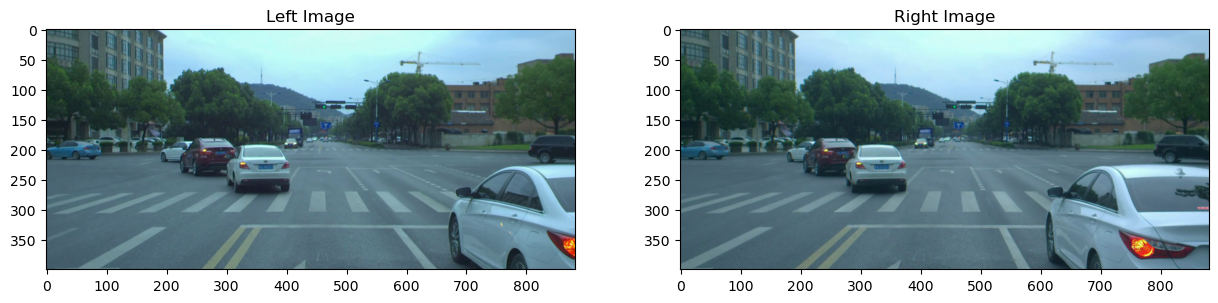

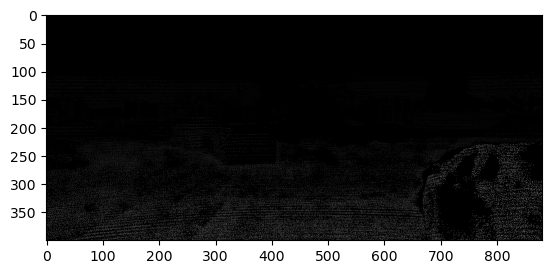

In [3]:
# Import images 
directory = './Dataset/'
allfiles = os.listdir(directory)

filenames = []

for filename in allfiles:
    if 'left' in filename:
        filenames.append(filename[0:filename.index('left')])

# List of files obtained

# Perform on first image for now 

file = filenames[0]

left_image_name = directory + file + 'left.jpg'
right_image_name = directory+ file + 'right.jpg'
disp_image_name = directory+ file + 'disparity.png'

# Read images and convert to RGB 
img_l = cv2.imread(left_image_name)
img_r = cv2.imread(right_image_name)

# Grey images
img_l_grey = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
img_r_grey = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)


img_l = img_l[...,::-1]
img_r = img_r[...,::-1]

# Plot images 
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_l)
plt.title('Left Image')

plt.subplot(1,2,2)
plt.imshow(img_r)
plt.title('Right Image')

plt.show()

img_d = cv2.imread(disp_image_name)
plt.imshow(img_d)

Text(0.5, 1.0, 'SSD')

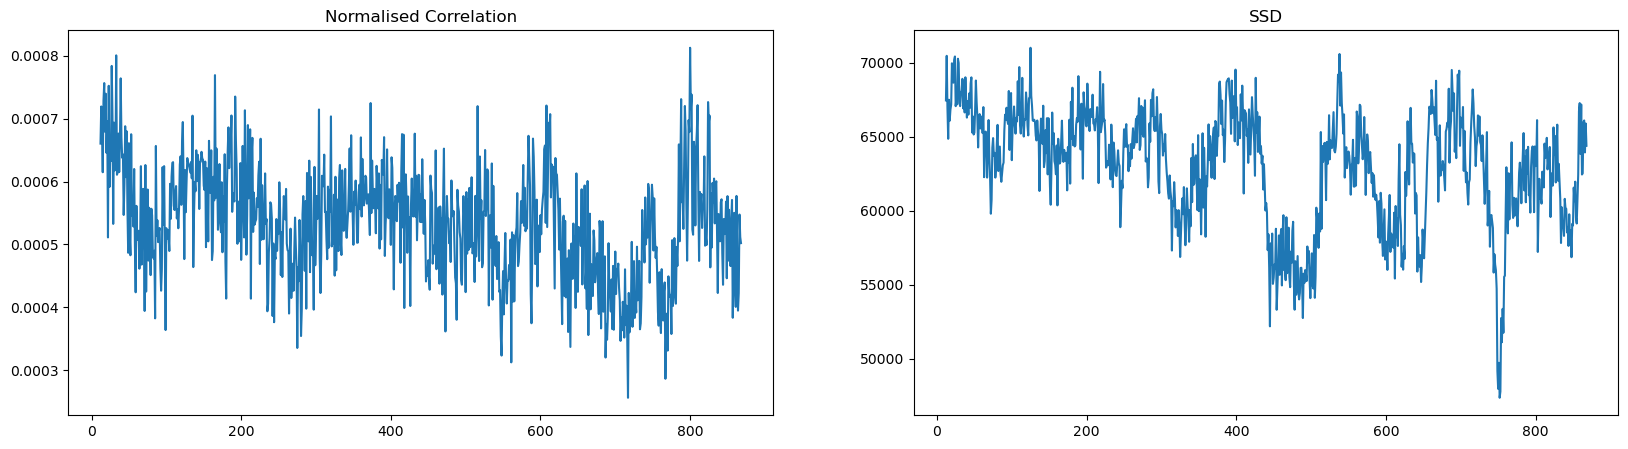

In [41]:
# As driving assume that any two points have the same y value (camera is flat)

# For every y value in both left and right
#     For every x value in left, find the corresponding SSD error (10x10 box) for each x point in right image
#     Select mininum error - treat this as corresponding point

# For every corresponding set of points, find the disparity, x-x'
#     Find depth z by estimating f and baseline distance


# Not certain if this function actually does what I imagine it does

# centre positions given by [row,column]

# sum of squared differenced method to find disparity between images   
def sum_squared_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size
    
    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum((patch_l - patch_r)**2)

    return error

def sum_absolute_differences(img_l, img_r, centre_l, centre_r, boundary_size):
    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size

    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size
    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size

    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    # Error of RGB values
    # error = np.sum((img_l[min_l_y:max_l_y,min_l_x:max_l_x,:] - img_r[min_r_y:max_r_y,min_r_x:max_r_x,:])**2)

    # Error of Grey values
    error = np.sum(abs(patch_l - patch_r))

    return error

    
def norm_correlation(img_l, img_r, centre_l, centre_r, boundary_size):

    # Column
    min_l_x = centre_l[1] - boundary_size
    max_l_x = centre_l[1] + boundary_size
    
    min_r_x = centre_r[1] - boundary_size
    max_r_x = centre_r[1] + boundary_size

    # Row
    min_l_y = centre_l[0] - boundary_size
    max_l_y = centre_l[0] + boundary_size

    min_r_y = centre_r[0] - boundary_size
    max_r_y = centre_r[0] + boundary_size
    
    patch_l = img_l[min_l_y:max_l_y,min_l_x:max_l_x]
    patch_r = img_r[min_r_y:max_r_y,min_r_x:max_r_x]

    sum = 0
    for i in range(len(patch_l)):
        sum += np.dot(patch_l[i], patch_r[i])

    norm_corr = sum/(np.linalg.norm(patch_l, 'fro')*np.linalg.norm(patch_r, 'fro'))
    return norm_corr

boundary_size = 12
row = 360
left_image = [row,860]
SSD = []
corr = []
pixel_loc = []
for i in range(boundary_size, len(img_l_grey[0])-boundary_size, 1):
    pixel_loc.append(i)
    corr.append(norm_correlation(img_l_grey, img_r_grey, left_image, [row,i], boundary_size))
    SSD.append(sum_squared_differences(img_l_grey, img_r_grey, left_image, [row,i], boundary_size))


plt.subplots(1,2, figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pixel_loc, corr)
plt.title('Normalised Correlation')

plt.subplot(1,2,2)
plt.plot(pixel_loc, SSD)
plt.title('SSD')



In [43]:
# Plot disparity image
h,w = img_l_grey.shape
calc_disp = np.zeros((h,w))
step_size = 4

for row_index in range(boundary_size, len(img_l_grey)-boundary_size, step_size):
    row = img_l_grey[row_index]

    # Should be the full bounds, but takes a very long time, consider using tensor operations on rows
    for col_index_left in range(boundary_size,len(row)-boundary_size, step_size):
        left_centre = [row_index, col_index_left]
        
        min_error = math.inf
        for col_index_right in range(boundary_size, len(row)-boundary_size, boundary_size//3):

            right_centre = [row_index, col_index_right]
            ssd_error = sum_squared_differences(img_l_grey, img_r_grey, left_centre, right_centre, boundary_size)

            if min_error > ssd_error:
                min_error = ssd_error
                min_col_index = col_index_right

        calc_disp[row_index][col_index_left] = abs(min_col_index - col_index_left)
        

plt.imshow(calc_disp, cmap='gray')
plt.savefig('disparity.png')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


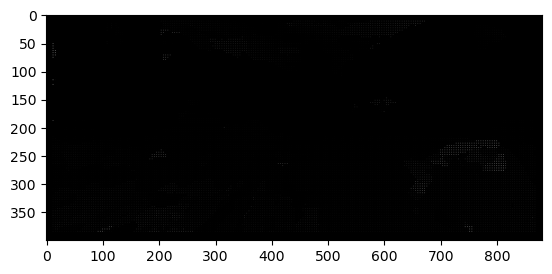

In [39]:
# Optimised disparity image calcualtion
h,w = img_l_grey.shape
calc_disp = np.zeros((h,w))
step_size = 4

for row_index in range(boundary_size, len(img_l_grey)-boundary_size, step_size):
    row = img_l_grey[row_index]

    # Should be the full bounds, but takes a very long time, consider using tensor operations on rows
    for col_index_left in range(boundary_size, len(row)-boundary_size, step_size):
        patch_l = img_l[row_index-boundary_size:row_index+boundary_size, col_index_left-boundary_size:col_index_left+boundary_size]
        min_error = math.inf
        for col_index_right in range(boundary_size, len(row)-boundary_size, boundary_size//3):

            patch_r = img_r[row_index-boundary_size:row_index+boundary_size, col_index_right-boundary_size:col_index_right+boundary_size]
            ssd_error = np.sum((patch_l - patch_r)**2)
            
            if min_error > ssd_error:
                min_error = ssd_error
                min_col_index = col_index_right

        calc_disp[row_index][col_index_left] = abs(min_col_index - col_index_left)

plt.imshow(calc_disp, cmap='gray')
plt.savefig('disparity.png')
print(calc_disp)